In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time 

In [2]:
# Download stock data
symbol = "TSLA"
data = yf.download(symbol, start="2020-01-01", end="2023-09-01")
price_data = data[['Close']].values

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(price_data).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed


In [3]:
# Split train and test set
train_size = int(len(scaled_data)*0.7) # 70% training, 30% testing
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:1]

def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

# calling the create dataset function to split the data into 
# input output datasets with time step 60
time_step = 60
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [4]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1))) # input layer, 50 neurons and 1 for output 
model.add(LSTM(50,return_sequences = True)) # hidden layer
model.add(LSTM(50)) # hidden layer
model.add(Dense(1)) # output layers
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# check the running time
start_time = time.time()

model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1) # 100 epochs, 64 batch size

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")

Epoch 1/100
10/10 [==============================] - 8s 241ms/step - loss: 0.1064 - val_loss: 0.0171
Epoch 2/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0158 - val_loss: 0.0052
Epoch 3/100
10/10 [==============================] - 1s 119ms/step - loss: 0.0103 - val_loss: 0.0051
Epoch 4/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 6/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 8/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 9/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 10/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0044 - val_lo

10/10 [==============================] - 1s 96ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 83/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 84/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0012 - val_loss: 9.7167e-04
Epoch 85/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 86/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 87/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0014 - val_loss: 9.8720e-04
Epoch 88/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0013 - val_loss: 9.6979e-04
Epoch 89/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0012 - val_loss: 9.1718e-04
Epoch 90/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0012 - val_loss: 9.0513e-04
Epoch 91/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0011 - 

In [6]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Y_train and Y_test are in scaled form, so we need to transform them back to original scale
Y_train_orig = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_orig = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(Y_train_orig, train_predict)))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test_orig, test_predict)))

7/7 [==============================] - 0s 21ms/step
Train RMSE: 12.60650960946874
Test RMSE: 12.276247452747413


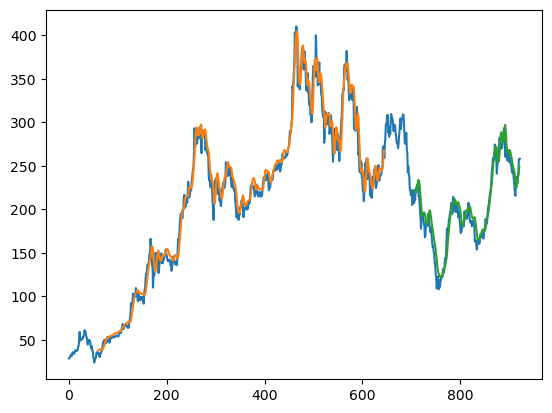

In [7]:
## Plotting
look_back = 60

trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(scaled_data) - 1,:] = test_predict

plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() ## Orange is the TrainPredictPlot, Green is TestPredictPlot